In [1]:
import math
import matplotlib.pyplot as plt
import random
from collections import Counter
import numpy as np

In [2]:
class RandomVariableSimulator:
    """
    Clase base para la simulación de variables aleatorias.

    Esta clase define la estructura general para generar muestras, calcular
    densidades/probabilidades y graficar resultados de variables aleatorias
    discretas o continuas.

    Métodos principales:
    -------------------
    generator()
        Debe ser implementado en la clase hija.
        Retorna una realización de la variable aleatoria.

    pdf(x)
        Debe ser implementado en la clase hija.
        Retorna la densidad (para continua) o probabilidad (para discreta)
        evaluada en x.

    sample(n)
        Genera una lista de n realizaciones de la variable aleatoria
        usando generator().

    plot(n=1000, rango=None, bins=50)
        Grafica la distribución de la variable aleatoria.
        - n: número de muestras a generar para el histograma/barplot.
        - rango: tupla (xmin, xmax) para limitar la gráfica continua.
        - bins: número de intervalos en el histograma (solo continua).

    Atributos:
    ----------
    kind : str
        Define si la variable es "discrete" o "continuous". Debe ser
        asignado en la clase hija antes de llamar a plot().
    """

    def __init__(self):
        self.kind = None  # Tipo de variable: 'discrete' o 'continuous'

    def generator(self):
        """
        Método abstracto que debe ser implementado en la clase hija.

        Retorna:
        --------
        float o int
            Una realización de la variable aleatoria.
        """
        raise NotImplementedError(
            "Debes implementar el método generator en la clase hija"
        )

    def pdf(self, x):
        """
        Método abstracto que debe ser implementado en la clase hija.

        Parámetros:
        -----------
        x : float o int
            Punto donde se evalúa la densidad o probabilidad.

        Retorna:
        --------
        float
            Valor de la densidad (continua) o probabilidad (discreta) en x.
        """
        raise NotImplementedError(
            "Debes implementar el método density en la clase hija"
        )

    def sample(self, n):
        """
        Genera n realizaciones de la variable aleatoria.

        Parámetros:
        -----------
        n : int
            Número de muestras a generar.

        Retorna:
        --------
        list
            Lista de n valores generados por generator().
        """
        return [self.generator() for _ in range(n)]

    def plot(self, n=1000, rango=None, bins=50):
        """
        Grafica la distribución de la variable aleatoria.

        Para variables discretas:
            - Se muestra un bar plot de la distribución empírica.
            - Se superpone la probabilidad teórica usando líneas y puntos.

        Para variables continuas:
            - Se muestra un histograma normalizado de la muestra.
            - Se superpone la densidad teórica usando una línea roja.

        Parámetros:
        -----------
        n : int, opcional
            Número de muestras para graficar (por defecto 1000).
        rango : tuple, opcional
            Tupla (xmin, xmax) para limitar la gráfica continua.
        bins : int, opcional
            Número de intervalos en el histograma (solo continua).

        Excepciones:
        ------------
        ValueError
            Si self.kind no está definido o tiene un valor inválido.
        """
        if self.kind is None:
            raise ValueError("Debes definir self.kind")

        data = self.sample(n)
        plt.figure()

        # -----------------------------
        # CASO DISCRETO
        # -----------------------------
        if self.kind == "discrete":
            
            counts = Counter(data)  # Conteo de ocurrencias
            x_vals = sorted(counts.keys())  # Valores únicos
            probs = [counts[x] / n for x in x_vals]  # Probabilidad empírica
            labels = [str(x) for x in x_vals]

            # Empírico — líneas verticales
            plt.bar(x_vals, probs, label="Empírica")

            # Teórica — probabilidad exacta
            theo = [self.pdf(x) for x in x_vals]
            plt.vlines(x_vals, [0], theo, colors='red', lw=2, alpha=0.9)
            plt.scatter(x_vals, theo, color='red', label="Teórica")

            plt.ylabel("Probabilidad")

        # -----------------------------
        # CASO CONTINUO
        # -----------------------------
        elif self.kind == "continuous":

            plt.hist(data, bins=bins, density=True,
                     range=rango, alpha=0.6, label="Empírica")

            # Determina rango de la curva teórica
            if rango is None:
                xmin = min(data)
                xmax = max(data)
            else:
                xmin, xmax = rango

            xs = np.linspace(xmin, xmax, 400)
            ys = [self.pdf(x) for x in xs]

            plt.plot(xs, ys, "r", lw=2, label="Teórica")
            plt.ylabel("Densidad")

        else:
            raise ValueError("self.kind debe ser 'discrete' o 'continuous'")

        plt.xlabel("Valores")
        plt.legend()
        plt.show()

## 🎲 Generador lineal congruencial (GLC)

El **generador lineal congruencial** es uno de los métodos más clásicos para producir números pseudoaleatorios.

### 📌 Definición

La sucesión se define mediante la recurrencia

$$
x_{n+1} = \mathrm{glc}(x_n) = a(x_n + c) \; \text{mod} \; m,
$$

y los números pseudoaleatorios normalizados se obtienen como

$$
u_n = \mathrm{gglc}(x_n) = \frac{x_n}{m}.
$$

donde:

- $a$ : multiplicador,
- $c$ : incremento,
- $m$ : módulo,
- $x_0$ : semilla inicial.

---

### ⚙️ Parámetros de Park y Miller (1988)

Park y Miller sugirieron la siguiente elección de parámetros:

$$
m = 2^{31} - 1, \qquad a = 7^5, \qquad c = 0.
$$

Este caso particular se conoce como el **minimal standard generator** y es ampliamente usado como referencia histórica en simulación.


In [3]:
class GLC(RandomVariableSimulator):
    """
    Generador Lineal Congruencial (GLC) para números pseudoaleatorios continuos.

    Este generador produce una secuencia de números uniformes en (0,1) usando la 
    recurrencia lineal congruencial:

        X_{n+1} = (a * X_n + c) mod m
        U_n = X_n / m

    Donde:
    - m : módulo
    - a : multiplicador
    - c : incremento
    - X_0 : semilla inicial

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().
    
    Atributos:
    ----------
    m : int
        Módulo del generador (por defecto 2**31 - 1).
    a : int
        Multiplicador (por defecto 7**5).
    c : int
        Incremento (por defecto 0).
    state : int
        Estado actual / semilla.
    kind : str
        Tipo de variable aleatoria: "continuous" (siempre 0 < U < 1).
    """

    def __init__(self, m=2**31 - 1, a=7**5, c=0, seed=1):
        """
        Inicializa el generador lineal congruencial con los parámetros dados.

        Parámetros:
        -----------
        m : int, opcional
            Módulo del generador (por defecto 2**31 - 1).
        a : int, opcional
            Multiplicador (por defecto 7**5).
        c : int, opcional
            Incremento (por defecto 0).
        seed : int, opcional
            Valor inicial del estado / semilla (por defecto 1).
        """
        super().__init__()

        self.m = m
        self.a = a
        self.c = c
        self.state = seed

        self.kind = "continuous"  # Siempre produce números en (0,1)

    def pdf(self, x):
        """
        Función de densidad teórica de la variable generada.

        Dado que el GLC genera números uniformes en (0,1), la densidad es:

            f(x) = 1  si 0 < x < 1
                 = 0  en otro caso

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad en x.
        """
        if 0 < x < 1:
            return 1
        else:
            return 0

    def generator(self):
        """
        Genera un número pseudoaleatorio uniforme en (0,1) usando la 
        recurrencia lineal congruencial.

        Actualiza el estado interno y retorna la realización normalizada.

        Retorna:
        --------
        float
            Número pseudoaleatorio en (0,1).
        """
        # Actualiza el estado según la fórmula del GLC
        self.state = (self.a * self.state + self.c) % self.m

        return self.state / self.m


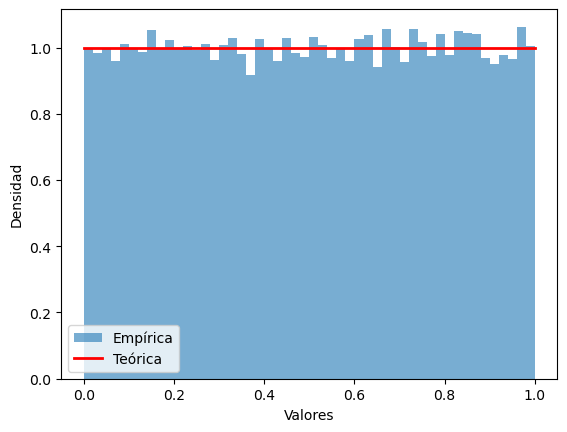

In [4]:
glc = GLC(seed=16230)
glc.plot(50000)

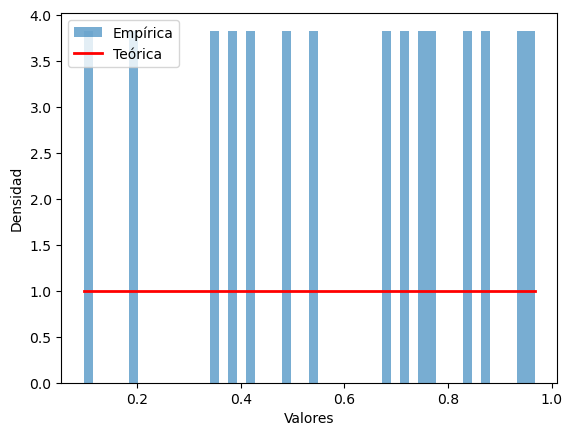

In [5]:
glc2 = GLC(seed=15672,a=2**3-1,c=0,m=2**5-1)
glc2.plot(10000)

In [6]:
#Generar números uniformes
random.seed(23)

for _ in range(10):
    
    print(random.random())

0.9248652516259452
0.9486057779931771
0.8924333440485793
0.08355067683068362
0.5920272268857353
0.4237474082349614
0.5300880101180064
0.13030294124748054
0.1919971575392927
0.444573573873013


# Transformada Inversa

## 🎲 Simulación usando $U \sim \mathrm{Uniforme}(0,1)$

### 🔹 Caso Bernoulli($p$)

Si tenemos acceso a una variable aleatoria $U \sim \mathrm{Uniforme}(0,1)$, 
podemos simular una variable

$$
X \sim \mathrm{Bernoulli}(p), \qquad 0 < p < 1,
$$

definiendo

$$
X = \mathbf{1}_{\{U \le p\}}.
$$

En efecto,

- $P(X=1) = P(U \le p) = p$,
- $P(X=0) = 1 - p$,

por lo que $X$ tiene distribución Bernoulli$(p)$.

---

### 🔹 Caso discreto general

Sea $X$ una variable aleatoria discreta que toma valores en

$$
\{x_1, x_2, \dots, x_n\},
$$

con probabilidades

$$
P[X = x_i] = p_i, \qquad i=1,\dots,n,
$$

donde

$$
\sum_{i=1}^{n} p_i = 1.
$$

Para simular $X$ usando $U \sim \mathrm{Uniforme}(0,1)$, definimos:

$$
X =
\begin{cases}
x_1, & \text{si } 0 < U \le p_1, \\
x_2, & \text{si } p_1 < U \le p_1 + p_2, \\
\vdots \\
x_n, & \text{si } p_1 + \cdots + p_{n-1} < U \le 1.
\end{cases}
$$

Este procedimiento se basa en dividir el intervalo $(0,1)$ según las
probabilidades acumuladas y asignar cada subintervalo a un valor posible de $X$.


In [7]:
class Bernoulli(RandomVariableSimulator):
    """
    Simulación de una variable aleatoria Bernoulli(p).

    La variable X toma solo dos valores:
        P(X = 1) = p
        P(X = 0) = 1 - p

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    p : float
        Probabilidad de éxito (X=1), debe estar en [0,1].
    kind : str
        Tipo de variable aleatoria: "discrete".
    """

    def __init__(self, p):
        """
        Inicializa la variable Bernoulli con la probabilidad p.

        Parámetros:
        -----------
        p : float
            Probabilidad de éxito (X=1), debe estar entre 0 y 1.

        Excepciones:
        ------------
        ValueError
            Si p no está en el intervalo [0,1].
        """
        if not (0 <= p <= 1):
            raise ValueError("El parámetro p debe estar en [0,1]")

        self.p = p
        self.kind = "discrete"  # Variable discreta

    def pdf(self, x):
        """
        Función de probabilidad de la variable Bernoulli.

        Parámetros:
        -----------
        x : int
            Valor a evaluar (0 o 1).

        Retorna:
        --------
        float
            Probabilidad P(X=x). Retorna 0 si x no es 0 ni 1.
        """
        if x == 1:  
            return self.p  
        elif x == 0:
            return 1 - self.p
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable Bernoulli(p).

        Usa un número uniforme aleatorio para decidir el resultado.

        Retorna:
        --------
        int
            1 con probabilidad p, 0 con probabilidad 1-p.
        """
        u = random.random()
        return 1 if u < self.p else 0


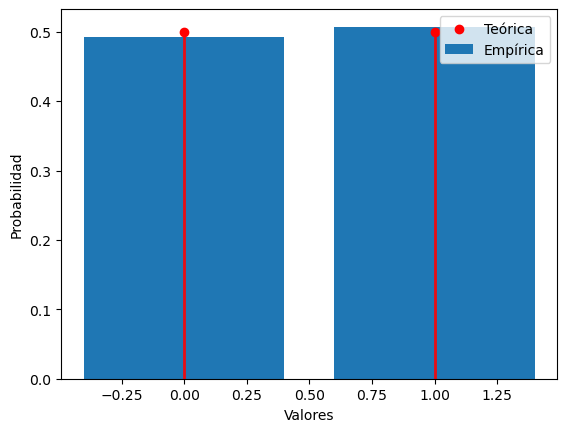

In [8]:
bern = Bernoulli(0.5)
bern.plot(5000)

In [9]:
class DiscretaGeneral(RandomVariableSimulator):
    """
    Generador de una variable aleatoria discreta general.

    Esta clase permite simular variables aleatorias discretas con valores
    y probabilidades arbitrarias usando el método de probabilidades acumuladas.

    Sea:
        Valores posibles: x1, x2, ..., xn
        Probabilidades:  p1, p2, ..., pn   con sum(pi)=1

    Procedimiento de generación:
    ----------------------------
    1. Genera U ~ Uniforme(0,1)
    2. Devuelve el valor xi tal que la probabilidad acumulada hasta xi
       supera a U.

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    valores : list
        Lista de valores posibles de la variable aleatoria.
    probabilidades : list
        Lista de probabilidades correspondientes a cada valor, deben sumar 1.
    kind : str
        Tipo de variable aleatoria: "discrete".
    pmf : dict
        Diccionario que asocia cada valor con su probabilidad.
    acumuladas : list
        Lista de probabilidades acumuladas para la generación.
    """

    def __init__(self, valores, probabilidades):
        """
        Inicializa la variable discreta general con los valores y probabilidades dadas.

        Parámetros:
        -----------
        valores : list
            Valores posibles de la variable aleatoria.
        probabilidades : list
            Probabilidades correspondientes a cada valor.

        Excepciones:
        ------------
        ValueError
            - Si valores y probabilidades no tienen la misma longitud.
            - Si las probabilidades no suman 1.
            - Si alguna probabilidad es negativa.
        """
        super().__init__()

        if len(valores) != len(probabilidades):
            raise ValueError("valores y probabilidades deben tener la misma longitud")

        if not abs(sum(probabilidades) - 1) < 1e-10:
            raise ValueError("Las probabilidades deben sumar 1")

        if any(p < 0 for p in probabilidades):
            raise ValueError("Las probabilidades deben ser no negativas")

        self.valores = valores
        self.probabilidades = probabilidades
        self.kind = "discrete"  # Variable discreta

        # Diccionario para la pmf
        self.pmf = dict(zip(valores, probabilidades))

        # Construcción de probabilidades acumuladas para la generación
        self.acumuladas = []
        acumulado = 0
        for p in probabilidades:
            acumulado += p
            self.acumuladas.append(acumulado)
            
    def pdf(self, x):
        """
        Función de probabilidad de la variable discreta.

        Parámetros:
        -----------
        x : valor
            Valor a evaluar.

        Retorna:
        --------
        float
            Probabilidad P(X=x). Retorna 0 si x no está en la lista de valores.
        """
        return self.pmf.get(x, 0.0)

    def generator(self):
        """
        Genera una realización de la variable discreta usando probabilidades acumuladas.

        Procedimiento:
        --------------
        1. Genera U ~ Uniforme(0,1)
        2. Devuelve el primer valor xi tal que U <= probabilidad acumulada hasta xi.

        Retorna:
        --------
        valor
            Una realización de la variable aleatoria discreta.
        """
        u = random.random()

        for valor, prob_acum in zip(self.valores, self.acumuladas):
            if u <= prob_acum:
                return valor


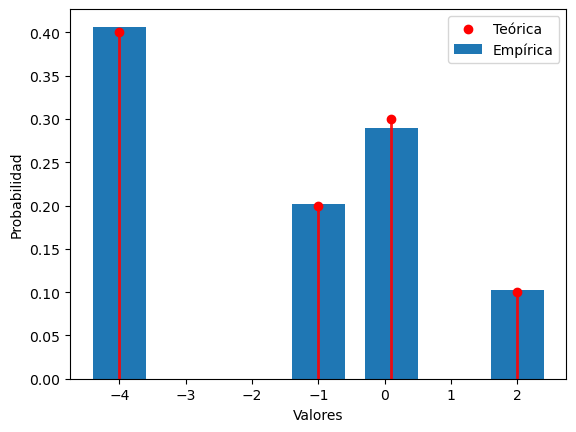

In [10]:
valores = [-1,0.1,2.0,-4]
probs = [0.2, 0.3, 0.1, 0.4]

dg = DiscretaGeneral(valores, probs)
dg.plot(5000)


## 🎲 Simulación de una uniforme $(a,b)$ usando $U \sim \mathrm{Uniforme}(0,1)$

Sea $X \sim \mathrm{Uniforme}(0,1)$.  
Podemos construir una variable aleatoria

$$
Y = (b-a)X + a,
$$

donde $a < b$, y entonces

$$
Y \sim \mathrm{Uniforme}(a,b).
$$

### 📌 Idea

La transformación

$$
T(x) = (b-a)x + a
$$

es una transformación lineal que:

- escala el intervalo $(0,1)$ a longitud $(b-a)$,
- y lo traslada para que comience en $a$.

En efecto,

- si $X \in (0,1)$ entonces $Y \in (a,b)$,
- y la densidad resultante es constante en $(a,b)$.

### 🔹 Procedimiento de simulación

1. Generar $X \sim \mathrm{Uniforme}(0,1)$.
2. Definir
   $$
   Y = (b-a)X + a.
   $$
3. El valor obtenido tiene distribución $\mathrm{Uniforme}(a,b)$.


In [11]:
class UniformeAB(RandomVariableSimulator):
    """
    Generador de una variable aleatoria continua Uniforme(a, b).

    La variable X toma valores en el intervalo [a, b] con densidad constante:

        f(x) = 1 / (b - a)  para a < x < b
               0             en otro caso

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    a : float
        Límite inferior del intervalo.
    b : float
        Límite superior del intervalo.
    kind : str
        Tipo de variable aleatoria: "continuous".
    """

    def __init__(self, a, b):
        """
        Inicializa la variable uniforme con los límites a y b.

        Parámetros:
        -----------
        a : float
            Límite inferior del intervalo.
        b : float
            Límite superior del intervalo (debe ser mayor que a).

        Excepciones:
        ------------
        ValueError
            Si b <= a.
        """
        super().__init__()

        if b <= a:
            raise ValueError("Se requiere a < b")

        self.a = a
        self.b = b
        self.kind = "continuous"  # Variable continua

    def pdf(self, x):
        """
        Función de densidad de la variable uniforme.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x). Retorna 0 si x no está en [a,b].
        """
        if self.a < x < self.b:
            return 1 / (self.b - self.a)
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable uniforme.

        Procedimiento:
        --------------
        1. Genera U ~ Uniforme(0,1)
        2. Escala y desplaza para obtener un valor en [a, b]

        Retorna:
        --------
        float
            Número pseudoaleatorio en el intervalo [a, b].
        """
        u = random.random()
        return (self.b - self.a) * u + self.a


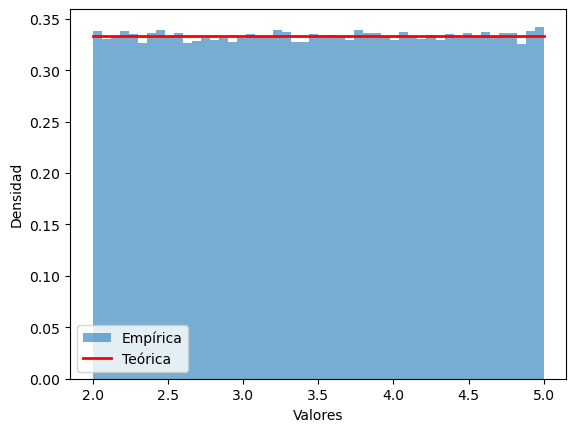

In [12]:
u = UniformeAB(2, 5)
u.plot(500000)

## 🎲 Simulación de una variable aleatoria Cauchy usando variables Uniformes

La distribución **Cauchy estándar** tiene densidad

$$
f(x)=\frac{1}{\pi(1+x^2)}, \qquad x \in \mathbb{R}.
$$

Existen dos transformaciones clásicas para simular una variable
$$
X \sim \mathrm{Cauchy}(0,1)
$$
a partir de variables Uniformes.

---

## 🔹 1. Usando $\Theta \sim \mathrm{Uniforme}(0,2\pi)$

Sea

$$
\Theta \sim \mathrm{Uniforme}(0,2\pi).
$$

Definimos la transformación

$$
X = \tan\!\left(\frac{\Theta}{2}\right).
$$

Entonces

$$
X \sim \mathrm{Cauchy}(0,1).
$$

### 📌 Idea

La transformación

$$
x = \tan(\theta/2)
$$

convierte un ángulo uniforme sobre el círculo en una variable real con
colas pesadas. El jacobiano del cambio de variable produce el factor
$(1+x^2)^{-1}$ característico de la densidad Cauchy.

Geométricamente:

- se toma un ángulo uniforme,
- se proyecta mediante la tangente,
- se obtiene una distribución Cauchy en la recta real.

---

## 🔹 2. Usando $U \sim \mathrm{Uniforme}(0,1)$ (transformada inversa)

Otra forma equivalente parte de

$$
U \sim \mathrm{Uniforme}(0,1).
$$

Definimos

$$
X = \tan\!\big(\pi(U - \tfrac12)\big).
$$

Entonces

$$
X \sim \mathrm{Cauchy}(0,1).
$$

### 📌 Justificación

La función de distribución acumulada (CDF) de la Cauchy estándar es

$$
F(x)=\frac12+\frac{1}{\pi}\arctan(x).
$$

Aplicando el método de la transformada inversa:

$$
U = F(X)
\quad \Rightarrow \quad
X = \tan\!\big(\pi(U-\tfrac12)\big).
$$

---

## ⭐ Observación

Ambas construcciones son equivalentes:

- $\Theta = 2\pi U$ con $U\sim U(0,1)$,
- sustituyendo en $X=\tan(\Theta/2)$ se obtiene
  $$
  X=\tan(\pi U).
  $$
- desplazando $U$ en $1/2$ se obtiene la forma simétrica más usada:
  $$
  X=\tan\!\big(\pi(U-\tfrac12)\big).
  $$

Esta segunda expresión suele preferirse en simulación numérica porque es
más directa y evita trabajar explícitamente con ángulos en $(0,2\pi)$.


In [13]:
class Cauchy(RandomVariableSimulator):
    """
    Generador de una variable aleatoria continua Cauchy(mu, gamma).

    La variable X tiene densidad de probabilidad:

        f(x) = 1 / [pi * gamma * (1 + ((x - mu)/gamma)^2)]

    Donde:
    - mu : ubicación (mediana)
    - gamma : escala positiva

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    mu : float
        Parámetro de ubicación de la distribución (mediana).
    gamma : float
        Parámetro de escala (debe ser > 0).
    kind : str
        Tipo de variable aleatoria: "continuous".
    """

    def __init__(self, mu=0, gamma=1):
        """
        Inicializa la variable Cauchy con parámetros mu y gamma.

        Parámetros:
        -----------
        mu : float, opcional
            Ubicación de la distribución (por defecto 0).
        gamma : float, opcional
            Escala positiva de la distribución (por defecto 1).

        Excepciones:
        ------------
        ValueError
            Si gamma <= 0.
        """
        super().__init__()

        if gamma <= 0:
            raise ValueError("gamma debe ser positiva")

        self.mu = mu
        self.gamma = gamma
        self.kind = "continuous"  # Variable continua

    def pdf(self, x):
        """
        Función de densidad de la distribución Cauchy.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x) en el punto x.
        """
        z = (x - self.mu) / self.gamma
        return 1 / (math.pi * self.gamma * (1 + z**2))

    def generator(self):
        """
        Genera una realización de la variable Cauchy usando la transformación
        inversa de la función de distribución.

        Procedimiento:
        --------------
        1. Genera U ~ Uniforme(0,1)
        2. Aplica la transformación inversa:
               X = mu + gamma * tan(pi * (U - 0.5))

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución Cauchy(mu, gamma).
        """
        u = random.random()
        return self.mu + self.gamma * math.tan(math.pi * (u - 0.5))


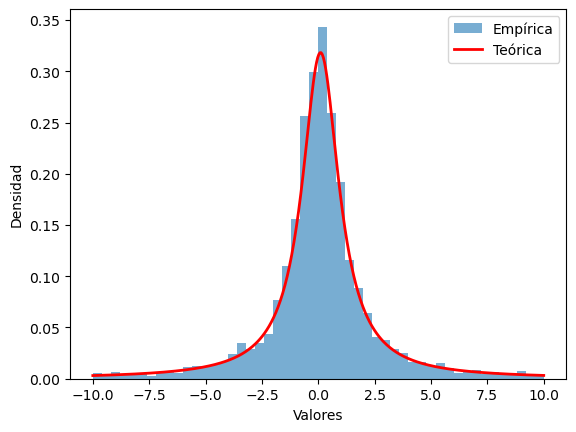

In [14]:
c = Cauchy(0.1)
c.plot(5000,rango=(-10,10))

## 🎲 Simulación de una variable Exponencial usando $U \sim \mathrm{Uniforme}(0,1)$

Sea $X$ una variable aleatoria con distribución exponencial de parámetro
$\lambda > 0$, cuya densidad es

$$
f(x)=\lambda e^{-\lambda x}, \qquad x \ge 0.
$$

---

## 🔹 Método de la transformada inversa

La función de distribución acumulada (CDF) de la exponencial es

$$
F(x)=1-e^{-\lambda x}.
$$

Si $U \sim \mathrm{Uniforme}(0,1)$, entonces por el método de la
transformada inversa:

$$
U = F(X) = 1 - e^{-\lambda X}.
$$

Despejando $X$:

$$
X = -\frac{1}{\lambda}\ln(1-U).
$$

Por lo tanto, si definimos

$$
X = -\frac{1}{\lambda}\ln(1-U),
$$

entonces

$$
X \sim \mathrm{Exponencial}(\lambda).
$$

---

## ⭐ Forma equivalente

Como $1-U \sim \mathrm{Uniforme}(0,1)$, también puede usarse

$$
X = -\frac{1}{\lambda}\ln(U),
$$

que es la forma más común en simulación computacional.


In [15]:
class Exponencial(RandomVariableSimulator):
    """
    Generador de una variable aleatoria continua Exponencial(lambda).

    La variable X tiene densidad de probabilidad:

        f(x) = lambda * exp(-lambda * x),  x >= 0

    Donde:
    - lambda : tasa positiva de la distribución

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    lambd : float
        Parámetro de tasa de la distribución (debe ser > 0).
    kind : str
        Tipo de variable aleatoria: "continuous".
    """

    def __init__(self, lambd=1):
        """
        Inicializa la variable Exponencial con parámetro lambda.

        Parámetros:
        -----------
        lambd : float, opcional
            Parámetro de tasa (por defecto 1).

        Excepciones:
        ------------
        ValueError
            Si lambd <= 0.
        """
        super().__init__()

        if lambd <= 0:
            raise ValueError("lambda debe ser positiva")

        self.lambd = lambd
        self.kind = "continuous"  # Variable continua

    def pdf(self, x):
        """
        Función de densidad de la distribución Exponencial.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x). Retorna 0 si x < 0.
        """
        if x >= 0:
            return self.lambd * math.exp(-self.lambd * x)
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable Exponencial usando la transformación inversa.

        Procedimiento:
        --------------
        1. Genera U ~ Uniforme(0,1)
        2. Aplica la transformación inversa:
               X = -ln(U) / lambda

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución Exponencial(lambda).
        """
        u = random.random()
        return -math.log(u) / self.lambd


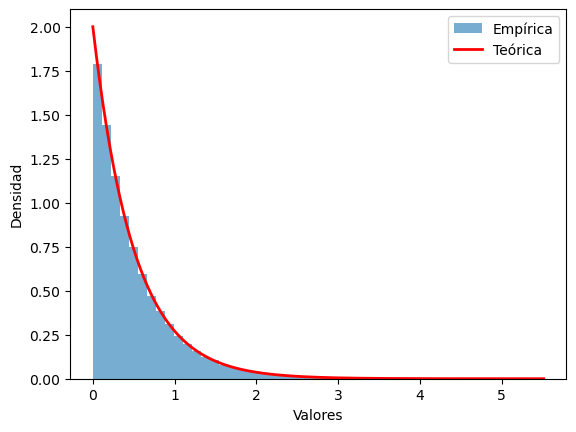

In [16]:
exp = Exponencial(lambd=2)

exp.plot(100000)

## 🎲 Simulación Erlang usando el producto de uniformes

Sea $X \sim \mathrm{Erlang}(k,\lambda)$ con $k \in \mathbb{N}$ y $\lambda>0$.

Si $U_1,\dots,U_k \sim \mathrm{Uniforme}(0,1)$ independientes, entonces

$$
X = -\frac{1}{\lambda}\ln\!\Big(\prod_{i=1}^{k} U_i\Big)
$$

sigue una distribución $\mathrm{Erlang}(k,\lambda)$.

### 📌 Idea

Sabemos que una exponencial puede generarse como

$$
E_i = -\frac{1}{\lambda}\ln(U_i).
$$

Entonces

$$
X=\sum_{i=1}^k E_i
= -\frac{1}{\lambda}\sum_{i=1}^k \ln(U_i)
= -\frac{1}{\lambda}\ln\!\Big(\prod_{i=1}^k U_i\Big).
$$

Esta forma es algebraicamente equivalente pero suele ser más compacta
y eficiente en implementación.


In [17]:
class Erlang(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Erlang (Gamma) con k entero positivo.

    Esta distribución es un caso especial de la distribución Gamma, con densidad:

        f(x) = (lambda^k / Gamma(k)) * x^(k-1) * exp(-lambda * x),  x >= 0

    Generación:
    -----------
    Se utiliza el método del producto de uniformes (suma de exponentiales):

        X = ( -ln(U1) - ln(U2) - ... - ln(Uk) ) / lambda
          = (sumatoria de k exponentiales) / lambda

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    k : int
        Parámetro de forma (entero positivo).
    lam : float
        Parámetro de tasa (lambda > 0).
    kind : str
        Tipo de variable aleatoria: "continuous".
    """

    def __init__(self, k, lam):
        """
        Inicializa la variable Erlang con parámetros k y lambda.

        Parámetros:
        -----------
        k : int
            Número de etapas (entero positivo).
        lam : float
            Parámetro de tasa (lambda > 0).

        Excepciones:
        ------------
        ValueError
            Si k no es un entero positivo o lambda <= 0.
        """
        super().__init__()

        if k <= 0 or int(k) != k:
            raise ValueError("k debe ser entero positivo")

        if lam <= 0:
            raise ValueError("lambda debe ser positiva")

        self.k = int(k)
        self.lam = lam
        self.kind = "continuous"  # Variable continua

    def pdf(self, x):
        """
        Función de densidad de la distribución Erlang.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x). Retorna 0 si x < 0.
        """
        if x >= 0:
            coef = (self.lam ** self.k) / math.gamma(self.k)
            return coef * (x ** (self.k - 1)) * math.exp(-self.lam * x)
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable Erlang usando suma de exponentiales.

        Procedimiento:
        --------------
        1. Genera k variables U_i ~ Uniforme(0,1)
        2. Suma -ln(U_i) para i=1..k
        3. Divide por lambda para obtener la realización

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución Erlang(k, lambda).
        """
        total = 0.0
        for _ in range(self.k):
            u = random.random()
            total += -math.log(u)
        return total / self.lam


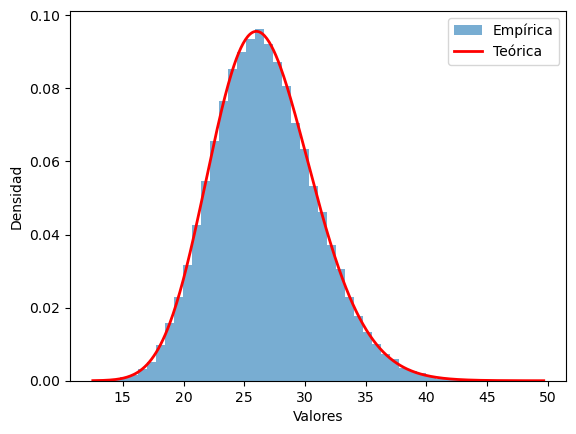

In [18]:
Er = Erlang(40, 1.5)
Er.plot(100000)

## 🎲 Simulación de una Binomial como suma de Bernoulli

La distribución **Binomial** puede construirse de forma natural a partir de variables Bernoulli, lo que permite simularla fácilmente usando únicamente variables Uniforme$(0,1)$.

---

### 📌 Idea básica

Recordemos que si

$$
X \sim \text{Bernoulli}(p),
$$

entonces puede generarse usando una uniforme

$$
U \sim \text{Uniforme}(0,1)
$$

mediante

$$
X = \mathbf{1}\{U \le p\}.
$$

---

### 🔁 Construcción de la Binomial

Sea

$$
X_1, X_2, \dots, X_n \sim \text{Bernoulli}(p) \quad \text{iid}.
$$

Entonces la suma

$$
S_n = X_1 + X_2 + \cdots + X_n
$$

sigue una distribución

$$
S_n \sim \text{Binomial}(n,p).
$$

---

### ⚙️ Algoritmo de simulación

Para generar una realización de $Y \sim \text{Binomial}(n,p)$:

1. Generar $U_1,\dots,U_n \sim \text{Uniforme}(0,1)$.
2. Definir

$$
X_i =
\begin{cases}
1, & U_i \le p, \\
0, & U_i > p.
\end{cases}
$$

3. Calcular

$$
Y = \sum_{i=1}^{n} X_i.
$$

---

### 🧠 Interpretación

La distribución binomial puede verse como el número de éxitos en $n$ ensayos independientes, donde cada ensayo se obtiene transformando una uniforme mediante una función indicadora. Esto muestra nuevamente cómo muchas distribuciones discretas pueden construirse a partir de Uniformes$(0,1)$.


In [19]:
class Binomial(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Binomial(n, p).

    La variable X cuenta el número de éxitos en n ensayos independientes de
    Bernoulli(p):

        X = suma de n Bernoulli(p)

    Distribución de probabilidad:

        P(X = k) = C(n, k) * p^k * (1-p)^(n-k),   k = 0, 1, ..., n

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    n : int
        Número de ensayos (entero positivo).
    p : float
        Probabilidad de éxito en cada ensayo (0 <= p <= 1).
    kind : str
        Tipo de variable aleatoria: "discrete".
    """

    def __init__(self, n, p):
        """
        Inicializa la variable Binomial con parámetros n y p.

        Parámetros:
        -----------
        n : int
            Número de ensayos (entero positivo).
        p : float
            Probabilidad de éxito en cada ensayo (0 <= p <= 1).

        Excepciones:
        ------------
        ValueError
            Si n no es un entero positivo o p no está en [0,1].
        """
        super().__init__()

        if n <= 0 or int(n) != n:
            raise ValueError("n debe ser entero positivo")

        if not (0 <= p <= 1):
            raise ValueError("p debe estar en [0,1]")

        self.n = int(n)
        self.p = p
        self.kind = "discrete"  # Variable discreta

    def pdf(self, k):
        """
        Función de probabilidad de la distribución Binomial.

        Parámetros:
        -----------
        k : int
            Número de éxitos a evaluar.

        Retorna:
        --------
        float
            Probabilidad P(X=k). Retorna 0 si k no es un entero entre 0 y n.
        """
        if k < 0 or k > self.n or int(k) != k:
            return 0.0
        else:
            comb = math.comb(self.n, int(k))
            return comb * (self.p ** k) * ((1 - self.p) ** (self.n - k))

    def generator(self):
        """
        Genera una realización de la variable Binomial(n, p) como suma de n Bernoulli(p).

        Procedimiento:
        --------------
        1. Para cada ensayo, genera un Bernoulli(p)
        2. Suma los éxitos para obtener X

        Retorna:
        --------
        int
            Número de éxitos observados en n ensayos.
        """
        total = 0
        for _ in range(self.n):
            if random.random() < self.p:
                total += 1
        return total


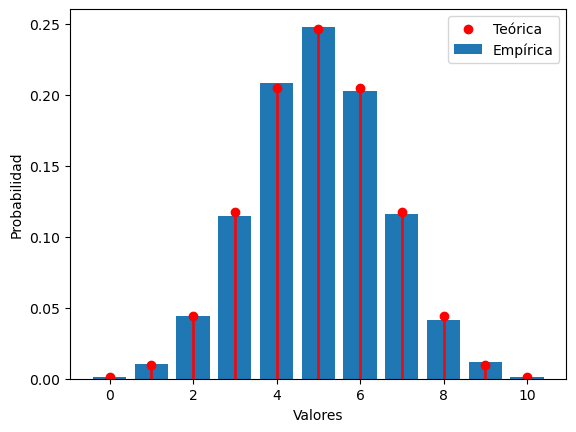

In [22]:
Bin = Binomial(10, 0.5)
Bin.plot(10000)

## 🎯 Simulación de la distribución Geométrica usando Transformada Inversa

Sea

$$
X \sim \text{Geom}(p),
$$

con función de probabilidad

$$
P(X=k) = (1-p)^{k-1}p, \quad k=1,2,3,\dots
$$

Esta variable representa el número de ensayos necesarios hasta obtener el primer éxito.

---

### 📌 Función de distribución acumulada

La CDF es

$$
F(k)=P(X\le k)=1-(1-p)^k.
$$

---

### 🧠 Método de la transformada inversa

Sea

$$
U \sim \text{Uniforme}(0,1).
$$

La inversa generalizada se define como

$$
X = \min \{k \in \mathbb{N} : F(k) \ge U \}.
$$

Entonces:

$$
1-(1-p)^k \ge U
$$

$$
(1-p)^k \le 1-U
$$

Tomando logaritmos:

$$
k \ge \frac{\log(1-U)}{\log(1-p)}.
$$

Por lo tanto,

$$
X =
\left\lceil
\frac{\log(1-U)}{\log(1-p)}
\right\rceil.
$$

Como $1-U$ también es uniforme, una forma equivalente es

$$
X =
\left\lfloor
\frac{\log(U)}{\log(1-p)}
\right\rfloor + 1.
$$

---

### ⚙️ Algoritmo

1. Generar $U \sim \text{Uniforme}(0,1)$.
2. Calcular

$$
X =
\left\lfloor
\frac{\log(U)}{\log(1-p)}
\right\rfloor + 1.
$$

Entonces $X \sim \text{Geom}(p)$.

---

### ⭐ Observaciones

- Método exacto.
- Muy eficiente (una sola uniforme).
- Mucho más rápido que repetir Bernoullis hasta éxito.


In [23]:
class Geometrica(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Geométrica(p).

    La variable X representa el número de ensayos hasta el primer éxito
    en ensayos independientes de Bernoulli(p):

        P(X = k) = p * (1 - p)^(k - 1),   k = 1, 2, 3, ...

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    p : float
        Probabilidad de éxito en cada ensayo (0 < p <= 1).
    kind : str
        Tipo de variable aleatoria: "discrete".
    """

    def __init__(self, p):
        """
        Inicializa la variable Geométrica con probabilidad p.

        Parámetros:
        -----------
        p : float
            Probabilidad de éxito en cada ensayo (0 < p <= 1).

        Excepciones:
        ------------
        ValueError
            Si p no está en (0,1].
        """
        super().__init__()

        if not (0 < p <= 1):
            raise ValueError("p debe estar en (0,1]")

        self.p = p
        self.kind = "discrete"  # Variable discreta

    def pdf(self, k):
        """
        Función de probabilidad de la distribución Geométrica.

        Parámetros:
        -----------
        k : int
            Número de ensayo hasta el primer éxito (k >= 1).

        Retorna:
        --------
        float
            Probabilidad P(X=k). Retorna 0 si k < 1 o no es entero.
        """
        if k < 1 or int(k) != k:
            return 0.0
        else:
            return self.p * ((1 - self.p) ** (k - 1))

    def generator(self):
        """
        Genera una realización de la variable Geométrica usando la transformación inversa.

        Procedimiento:
        --------------
        1. Genera U ~ Uniforme(0,1)
        2. Aplica la transformación inversa:
               X = floor( log(U) / log(1 - p) ) + 1

        Retorna:
        --------
        int
            Número de ensayos hasta el primer éxito.
        """
        u = random.random()
        return math.floor(math.log(u) / math.log(1 - self.p)) + 1


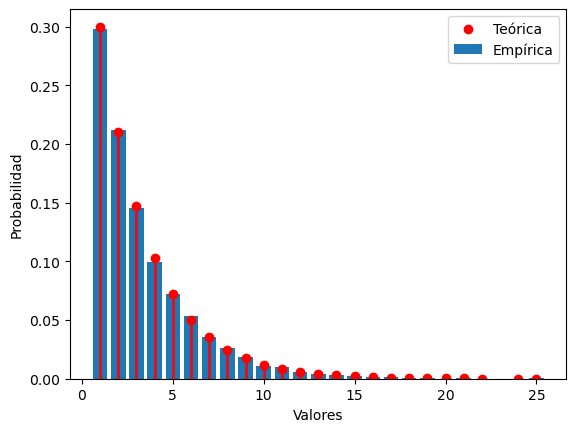

In [24]:
g = Geometrica(0.3)
g.plot(10000)

## 🎯 Simulación de una variable con densidad  $$ f(x)=\frac{1}{x}$$  en $[1,e]$

Queremos simular una variable aleatoria continua cuya densidad es

$$
f(x)=\frac{1}{x}, \quad 1 \le x \le e.
$$

---

### 📌 Verificación de que es una densidad válida

Comprobamos que integra 1:

$$
\int_1^e \frac{1}{x}\,dx
=
\ln(e) - \ln(1)
=
1.
$$

✔ Está correctamente normalizada.

---

### 🧠 Método: Transformada Inversa

Para usar el método de transformación inversa necesitamos la función de distribución acumulada (CDF).

---

$ $e la CDF

Para \(1 \le x \le e\),

$$
F(x)
=
\int_1^x \frac{1}{t}\,dt
=
\ln(x).
$$

---

### 2️⃣ Igualamos a una uniforme

Sea

$$
U \sim \text{Uniforme}(0,1).
$$

Igualamos:

$$
U = F(x) = \ln(x).
$$

Despejamos \(x\):

$$
x = e^{U}.
$$

---

### ✨ Resultado final

Si

$$
U \sim \text{Uniforme}(0,1),
$$

entonces

$$
X = e^{U}
$$

tiene densidad

$$
f(x)=\frac{1}{x}, \quad 1 \le x \le e.
$$

---

### 🧠 Interpretación

Esta variable puede verse como una **Uniforme en escala logarítmica**, ya que

$$
\ln(X) \sim \text{Uniforme}(0,1).
$$

Es uno de los ejemplos más limpios y elegantes del método de transformación inversa.
0,1).
$$

Es uno de los ejemplos más limpios y elegantes del método de transformación inversa.
bablemente una de las simulaciones más limpias que existen.


In [25]:
class LogUniforme(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Log-Uniforme en el intervalo [1, e].

    La variable X tiene densidad de probabilidad:

        f(x) = 1 / x,   1 <= x <= e

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    kind : str
        Tipo de variable aleatoria: "continuous".
    """

    def __init__(self):
        """
        Inicializa la variable Log-Uniforme en [1, e].
        """
        super().__init__()
        self.kind = "continuous"  # Variable continua

    def pdf(self, x):
        """
        Función de densidad de la distribución Log-Uniforme.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x). Retorna 0 si x no está en [1, e].
        """
        if 1.0 <= x <= math.e:
            return 1 / x
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable Log-Uniforme usando la transformación inversa.

        Procedimiento:
        --------------
        1. Genera U ~ Uniforme(0,1)
        2. Aplica la transformación inversa:
               X = exp(U)

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución Log-Uniforme en [1, e].
        """
        u = random.random()
        return math.exp(u)



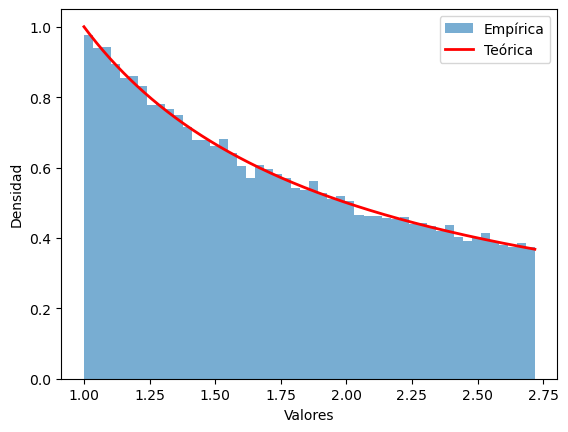

In [26]:
x = LogUniforme()
x.plot(100000, rango=(1, math.e))

## 🎯 Simulación de la distribución Normal usando el método de Box–Muller

Queremos generar una variable aleatoria

$$
X \sim \mathcal{N}(\mu,\sigma^2).
$$

La estrategia consiste en generar primero una normal estándar

$$
Z \sim \mathcal{N}(0,1)
$$

y luego transformar mediante

$$
X = \mu + \sigma Z.
$$

---

### 🧠 Método de Box–Muller

Sea

$$
U_1, U_2 \sim \text{Uniforme}(0,1)
$$

independientes. Entonces las variables

$$
Z_1 =
\sqrt{-2\log(U_1)}\cos(2\pi U_2),
$$

$$
Z_2 =
\sqrt{-2\log(U_1)}\sin(2\pi U_2)
$$

son independientes y siguen una distribución

$$
\mathcal{N}(0,1).
$$

Por lo tanto, una normal general se obtiene como

$$
X = \mu + \sigma Z_1.
$$

---

### ⚙️ Algoritmo de simulación

1. Generar $U_1, U_2 \sim \text{Uniforme}(0,1)$ independientes.
2. Calcular

$$
Z =
\sqrt{-2\log(U_1)}\cos(2\pi U_2).
$$

3. Transformar

$$
X = \mu + \sigma Z.
$$

---

### 🧠 Interpretación geométrica

El método proviene de expresar la distribución normal bivariada en coordenadas polares.  
La variable radial tiene densidad proporcional a

$$
r e^{-r^2/2},
$$

lo que permite obtener una transformación exacta desde variables uniformes.

---

### ⭐ Observaciones

- El método genera **dos normales independientes** por iteración.
- Es exacto (no aproximado).
- Es uno de los algoritmos clásicos más utilizados en simulación.

---

### 🚀 Caso especial: Normal estándar

Cuando $\mu=0$ y $\sigma=1$:

$$
Z =
\sqrt{-2\log(U_1)}\cos(2\pi U_2).
$$

---


In [27]:
class Normal(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Normal (Gaussiana) N(mu, sigma^2).

    La variable X tiene densidad de probabilidad:

        f(x) = 1 / (sigma * sqrt(2*pi)) * exp(-(x - mu)^2 / (2 * sigma^2))

    Generación:
    -----------
    Se utiliza el método de Box-Muller para generar números normales a partir
    de uniformes independientes U(0,1).

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    mu : float
        Media de la distribución.
    sigma : float
        Desviación estándar (sigma > 0).
    kind : str
        Tipo de variable aleatoria: "continuous".
    """

    def __init__(self, mu=0, sigma=1):
        """
        Inicializa la variable Normal con media mu y desviación sigma.

        Parámetros:
        -----------
        mu : float, opcional
            Media de la distribución (por defecto 0).
        sigma : float, opcional
            Desviación estándar (por defecto 1).

        Excepciones:
        ------------
        ValueError
            Si sigma <= 0.
        """
        if sigma <= 0:
            raise ValueError("sigma debe ser positiva")

        self.mu = mu
        self.sigma = sigma
        self.kind = "continuous"  # Variable continua

    def pdf(self, x):
        """
        Función de densidad de la distribución Normal.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x) en el punto x.
        """
        coef = 1 / (self.sigma * math.sqrt(2 * math.pi))
        expo = math.exp(-((x - self.mu) ** 2) / (2 * self.sigma ** 2))
        return coef * expo

    def generator(self):
        """
        Genera una realización de la variable Normal usando Box-Muller.

        Procedimiento:
        --------------
        1. Genera dos uniformes independientes U1, U2 ~ Uniforme(0,1)
        2. Aplica la transformación Box-Muller:
               Z = sqrt(-2 * ln(U1)) * cos(2 * pi * U2)
        3. Escala y desplaza para obtener X = mu + sigma * Z

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución Normal(mu, sigma^2).
        """
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        return self.mu + self.sigma * z


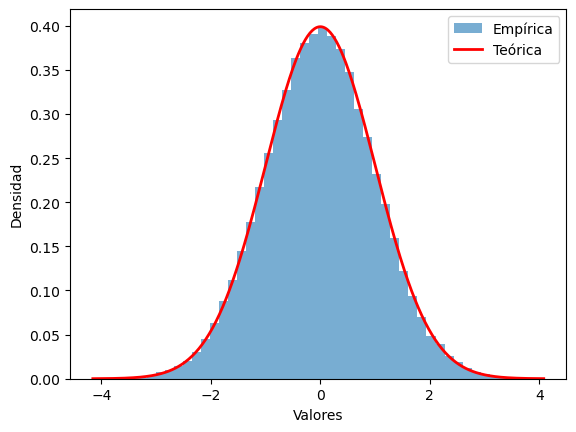

In [28]:
n = Normal(0, 1)
n.plot(100000)

## Simulación de una Variable Poisson usando Tiempos Exponenciales

Una forma muy elegante de simular una variable aleatoria Poisson consiste en usar la relación entre:

- El **proceso de Poisson**
- Los **tiempos entre llegadas exponenciales*#*

## Idea teórica

Sea un proceso de Poisson con tasa $ \lambda > 0 $.

Se sabe que:

- Los tiempos entre eventos consecutivos son variables independientes

$$
E_1, E_2, E_3, \dots \sim \text{Exp}(\lambda)
$$

- El tiempo del evento número $ n $ es

$$
T_n = E_1 + E_2 + \cdots + E_n
$$

Entonces, el número de eventos que ocurren en el intervalo $[0,1]$ es

$$
N = \max \{ n : T_n \le 1 \}
$$

y se cumple

$$
N \sim \text{Poisson}(\lambda)
$$

Por lo tanto, para simular una Poisson basta generar tiempos exponenciales, acumularlos y contar cuántos evento#s ocurren antes de tiempo 1.

---

## Interpretación intuitiva

Estamos simulando literalmente un **proceso de eventos en el tiempo**:

- Cada exponencial es el tiempo hasta el siguiente evento
- Contamos cuántos eventos caben en una ventana de longitud 1

Eso pr#oduce exactamente una variable Poisson.

---

## Comentarios importantes

✅ Este método es exacto  
✅ Tiene interpretación probabilística clara  
✅ Funciona muy bien cuando $ \lambda $ es moderado  

Sin embargo:

-. i $ \lambda $ es grande → puede ser lento (muchos eventos)

En ese caso existen otros métodos más eficientes.

---
)

En ese caso existen otros métodos más eficientes.

---

E = -\frac{1}{\lambda}\log(U)
$$

sigue una distribución exponencial con tasa $\lambda$.


In [29]:
class Poisson(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Poisson(lambda).

    La variable X cuenta el número de eventos en un intervalo de tiempo fijo
    bajo un proceso de Poisson con tasa lambda:

        P(X = k) = exp(-lambda) * lambda^k / k!,   k = 0, 1, 2, ...

    Generación:
    -----------
    Se utiliza un método basado en tiempos de espera exponenciales:
        1. Generar tiempos de espera E_i ~ Exponencial(lambda)
        2. Contar cuántos E_i se acumulan hasta superar 1

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator() y pdf().

    Atributos:
    ----------
    lam : float
        Tasa de ocurrencia (lambda > 0).
    kind : str
        Tipo de variable aleatoria: "discrete".
    """

    def __init__(self, lam):
        """
        Inicializa la variable Poisson con parámetro lambda.

        Parámetros:
        -----------
        lam : float
            Tasa de ocurrencia de eventos (lambda > 0).

        Excepciones:
        ------------
        ValueError
            Si lambda <= 0.
        """
        super().__init__()

        if lam <= 0:
            raise ValueError("lambda debe ser positiva")

        self.lam = lam
        self.kind = "discrete"  # Variable discreta

    def pdf(self, k):
        """
        Función de probabilidad de la distribución Poisson.

        Parámetros:
        -----------
        k : int
            Número de eventos a evaluar (k >= 0).

        Retorna:
        --------
        float
            Probabilidad P(X=k). Retorna 0 si k no es entero >= 0.
        """
        if k >= 0 and int(k) == k:
            return math.exp(-self.lam) * (self.lam ** k) / math.factorial(k)
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable Poisson usando tiempos de espera exponenciales.

        Procedimiento:
        --------------
        1. Inicializa t = 0 y n = 0
        2. Mientras t <= 1:
            a. Genera u ~ Uniforme(0,1)
            b. Calcula e = -ln(u) / lambda (Exponencial(lambda))
            c. Incrementa t += e
            d. Si t <= 1, incrementa n
        3. Retorna n

        Retorna:
        --------
        int
            Número de eventos ocurridos en el intervalo.
        """
        t = 0.0
        n = 0
        while t <= 1:
            u = random.random()
            e = -math.log(u) / self.lam
            t += e
            if t <= 1:
                n += 1
        return n


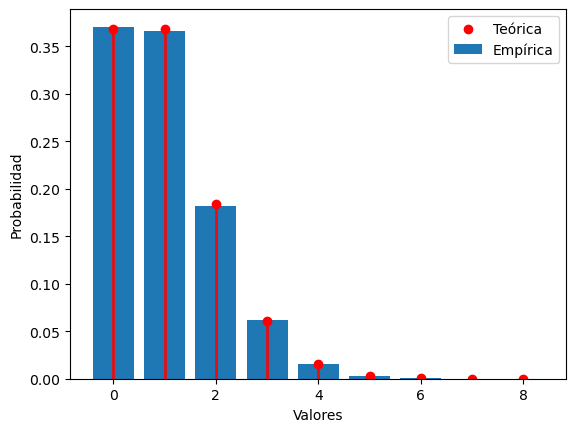

In [30]:
poi = Poisson(1)
poi.plot(100000)

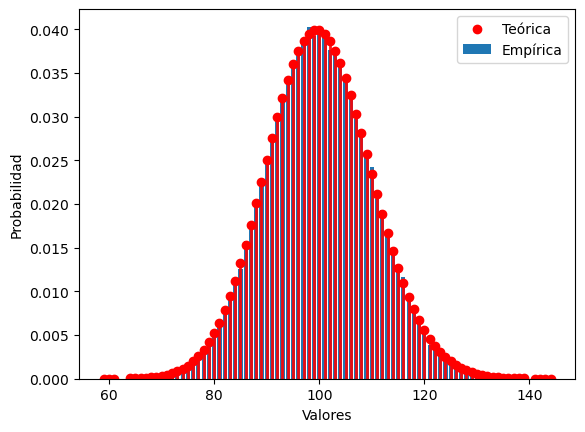

In [31]:
poi2 = Poisson(100)
poi2.plot(100000)

## 🎯 Simulación por Aceptación–Rechazo  
### Densidad semicircular $ \sqrt{1-x^2} $ en $[-1,1]$

Queremos generar una variable aleatoria con densidad

$$
f(x)=\sqrt{1-x^2}, \qquad -1\le x \le 1.
$$

Primero verificamos la constante de normalización:

$$
\int_{-1}^{1}\sqrt{1-x^2}\,dx
=
\frac{\pi}{2}.
$$

Por lo tanto, la densidad normalizada es

$$
f(x)=\frac{2}{\pi}\sqrt{1-x^2}.
$$

Esta es la **distribución semicircular**.

---

## 🧠 Método de Aceptación y Rechazo

Elegimos como distribución propuesta:

$$
g(x)=\text{Uniforme}(-1,1),
$$

porque es fácil de simular.

Sabemos que

$$
g(x)=\frac{1}{2}.
$$

Buscamos una constante $M$ tal que

$$
f(x)\le M g(x).
$$

El máximo de $f(x)$ ocurre en $x=0$:

$$
f(0)=\frac{2}{\pi}.
$$

Entonces:

$$
M=\frac{4}{\pi}.
$$

---

## ⚙️ Regla de aceptación

Si $X\sim \text{Uniforme}(-1,1)$ y $U\sim \text{Uniforme}(0,1)$,

aceptamos $X$ si

$$
U \le \sqrt{1-X^2}.
$$


In [32]:
class Semicircular(RandomVariableSimulator):
    """
    Generador de una variable aleatoria con densidad semicircular.

    La densidad de probabilidad es:

        f(x) = (2/pi) * sqrt(1 - x^2),   -1 <= x <= 1

    Generación:
    -----------
    Se utiliza el método de aceptación-rechazo con propuesta Uniforme(-1,1):

        1. Genera X ~ Uniforme(-1,1)
        2. Genera U ~ Uniforme(0,1)
        3. Acepta X si U <= sqrt(1 - X^2)
        4. Si se rechaza, X se guarda en self.rejected

    Hereda de RandomVariableSimulator y sobrescribe los métodos generator(), pdf() y sample().

    Atributos:
    ----------
    kind : str
        Tipo de variable aleatoria: "continuous".
    rejected : list
        Lista de realizaciones rechazadas durante la generación.
    T_ar : float
        Constante máxima de la función de aceptación para AR.
    """

    def __init__(self):
        """
        Inicializa la variable Semicircular.
        """
        self.kind = "continuous"
        self.rejected = []  # Para almacenar valores rechazados
        self.T_ar = math.pi / 4  # Constante de aceptación-rechazo

    def generator(self):
        """
        Genera una realización de la variable Semicircular usando
        aceptación-rechazo con propuesta Uniforme(-1,1).

        Procedimiento:
        --------------
        1. Genera x ~ Uniforme(-1,1)
        2. Genera u ~ Uniforme(0,1)
        3. Acepta x si u <= sqrt(1 - x^2), si no, guarda x en self.rejected
        4. Repite hasta aceptar un valor

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución semicircular.
        """
        while True:
            x = 2 * random.random() - 1
            u = random.random()
            if u <= math.sqrt(1 - x**2):
                return x
            self.rejected.append(x)

    def pdf(self, x):
        """
        Función de densidad de la distribución semicircular.

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x). Retorna 0 si x no está en [-1,1].
        """
        if -1 <= x <= 1:
            return 2 / math.pi * math.sqrt(1 - x**2)
        else:
            return 0.0

    def sample(self, n):
        """
        Genera n realizaciones de la variable semicircular y reinicia la lista
        de valores rechazados.

        Parámetros:
        -----------
        n : int
            Número de realizaciones a generar.

        Retorna:
        --------
        list
            Lista de n números pseudoaleatorios con distribución semicircular.
        """
        self.rejected = []  # Reinicia valores rechazados
        return [self.generator() for _ in range(n)]


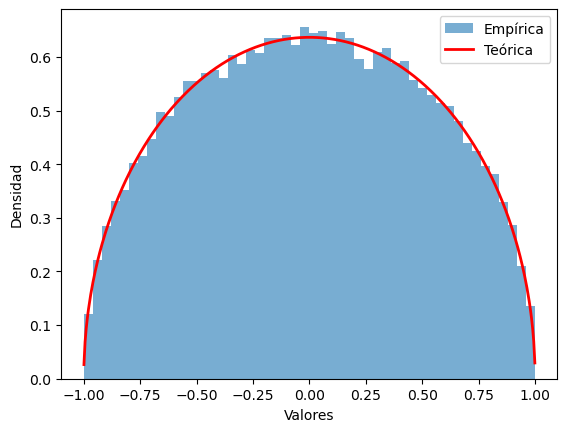

T_AR: 0.7854
E_AR: 0.7867


In [33]:
sc = Semicircular()
n = 100000
sc.plot(n)
r = len(sc.rejected)
E_ar = n/(n+r)
print('T_AR: {:.4f}'.format(sc.T_ar))
print('E_AR: {:.4f}'.format(E_ar))

# Simulación Gamma con Método de Aceptación y Rechazo

Queremos simular una variable aleatoria con densidad Gamma:

$$
p(x) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} e^{-\beta x}, 
\qquad x \ge 0,
$$

con parámetros:

- Forma: $\alpha \ge 1$
- Tasa: $\beta > 0$

---

## Idea del método

Se usa como envolvente otra distribución Gamma:

$$
q(x) \propto x^{\alpha_p - 1} e^{-\beta_p x},
$$

donde:

$$
\alpha_p = \lfloor \alpha \rfloor
$$

es la parte entera de $\alpha$.

Los parámetros se eligen para que:

- La envolvente tenga el mismo máximo que la densidad objetivo
- Se cumpla:

$$
p(x) \le K_p \, q(x)
$$

para todo $x \ge 0$.

---

## Parámetros

### Caso $\alpha \ge 2$

$$
\beta_p = \beta \frac{\alpha_p - 1}{\alpha - 1}
$$

$$
K_p = \exp(\alpha_p - \alpha)
\left(\frac{\alpha - 1}{\beta}\right)^{\alpha - \alpha_p}
$$

---

### Caso $1 \le \alpha < 2$

$$
\alpha_p = 1
$$

$$
\beta_p = \frac{\beta}{\alpha}
$$

$$
K_p =
\exp(1-\alpha)
\left(\frac{\alpha}{\beta}\right)^{\alpha-1}
$$

---

## Algoritmo

1. Calcular $\alpha_p$, $\beta_p$, $K_p$
2. Generar:

$$
X \sim \text{Gamma}(\alpha_p, \beta_p)
$$

3. Aceptar con probabilidad:

$$
\frac{p(X)}{K_p q(X)}
$$

4. Repetir hasta aceptar

---

Este método es eficiente porque:

- La Gamma propuesta se puede simular directamente
- La tasa de aceptación es alta cuando $\alpha$ es grande

In [34]:
class GammaAR(RandomVariableSimulator):
    """
    Generador de una variable aleatoria Gamma(alpha, beta) usando
    el método de aceptación-rechazo (AR).

    Esta implementación requiere alpha >= 1 y utiliza una propuesta
    basada en Gamma(entera) para generar la variable.

    Distribución:
    -------------
        f(x) = (beta^alpha / Gamma(alpha)) * x^(alpha-1) * exp(-beta * x),  x > 0

    Generación (AR):
    ----------------
    1. Se elige una propuesta Gamma(alpha_p, beta_p) con alpha_p = floor(alpha) >= 1
    2. Se genera x ~ propuesta
    3. Se acepta x con probabilidad f(x)/(K * proposal_pdf(x)), sino se rechaza
       y se guarda en self.rejected

    Hereda de RandomVariableSimulator y sobrescribe generator(), pdf() y sample().

    Atributos:
    ----------
    kind : str
        Tipo de variable aleatoria: "continuous".
    rejected : list
        Lista de realizaciones rechazadas durante la generación.
    alpha : float
        Parámetro de forma de la Gamma (alpha >= 1).
    beta : float
        Parámetro de tasa de la Gamma (beta > 0).
    alpha_p : int
        Parte entera usada para la propuesta.
    beta_p : float
        Tasa usada para la propuesta.
    Kp : float
        Constante de aceptación-rechazo.
    """

    def __init__(self, alpha, beta):
        """
        Inicializa la variable GammaAR con parámetros alpha y beta.

        Parámetros:
        -----------
        alpha : float
            Parámetro de forma (alpha >= 1).
        beta : float
            Parámetro de tasa (beta > 0).

        Excepciones:
        ------------
        ValueError
            Si alpha < 1.
        """
        if alpha < 1:
            raise ValueError("Este método requiere alpha >= 1")

        self.kind = 'continuous'
        self.rejected = []

        self.alpha = alpha
        self.beta = beta

        self.alpha_p = int(math.floor(alpha))

        # Parámetros de la propuesta
        if alpha >= 2:
            self.beta_p = beta * (self.alpha_p - 1) / (alpha - 1)
            self.Kp = math.exp(self.alpha_p - alpha) * ((alpha - 1) / beta) ** (alpha - self.alpha_p)
        else:
            self.alpha_p = 1
            self.beta_p = beta / alpha
            self.Kp = math.exp(1 - alpha) * (alpha / beta) ** (alpha - 1)

    def proposal(self):
        """
        Genera una realización de la propuesta Gamma(alpha_p, beta_p)
        usando el producto de uniformes.

        Retorna:
        --------
        float
            Valor de la propuesta.
        """
        prod = 1.0
        for _ in range(self.alpha_p):
            prod *= random.random()
        return -math.log(prod) / self.beta_p

    def pdf(self, x):
        """
        Función de densidad de la distribución Gamma(alpha, beta).

        Parámetros:
        -----------
        x : float
            Punto donde se evalúa la densidad.

        Retorna:
        --------
        float
            Valor de la densidad f(x). Retorna 0 si x <= 0.
        """
        if x > 0:
            coef = (self.beta ** self.alpha) / math.gamma(self.alpha)
            return coef * (x ** (self.alpha - 1)) * math.exp(-self.beta * x)
        else:
            return 0.0

    def generator(self):
        """
        Genera una realización de la variable Gamma(alpha, beta) usando
        aceptación-rechazo.

        Procedimiento:
        --------------
        1. Genera x ~ propuesta
        2. Calcula ratio = f(x) / (Kp * propuesta_pdf(x))
        3. Acepta x si U <= ratio, sino lo rechaza y lo guarda en self.rejected
        4. Repite hasta aceptar un valor

        Retorna:
        --------
        float
            Número pseudoaleatorio con distribución Gamma(alpha, beta).
        """
        while True:
            x = self.proposal()
            ratio = (x ** (self.alpha - 1) * math.exp(-self.beta * x)) / \
                    (self.Kp * x ** (self.alpha_p - 1) * math.exp(-self.beta_p * x))
            if random.random() <= ratio:
                return x
            self.rejected.append(x)

    def sample(self, n):
        """
        Genera n realizaciones de la variable GammaAR y reinicia la lista
        de valores rechazados.

        Parámetros:
        -----------
        n : int
            Número de realizaciones a generar.

        Retorna:
        --------
        list
            Lista de n números pseudoaleatorios con distribución Gamma(alpha, beta).
        """
        self.rejected = []  # Reinicia valores rechazados
        return [self.generator() for _ in range(n)]


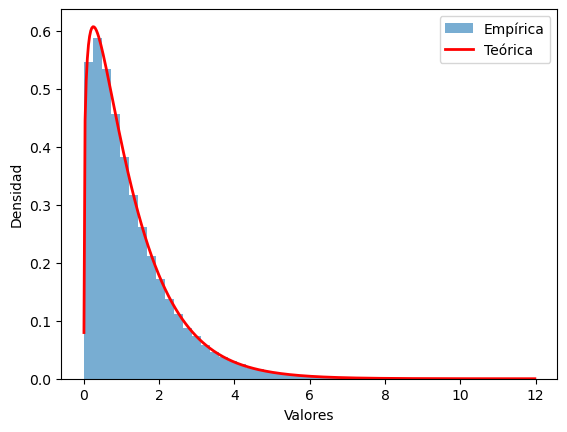

AR: 0.8795


In [35]:
gam_ar = GammaAR(1.25,1)
n = 100000
gam_ar.plot(n)
r = len(gam_ar.rejected)
E_ar = n/(n+r)
print('AR: {:.4f}'.format(E_ar))

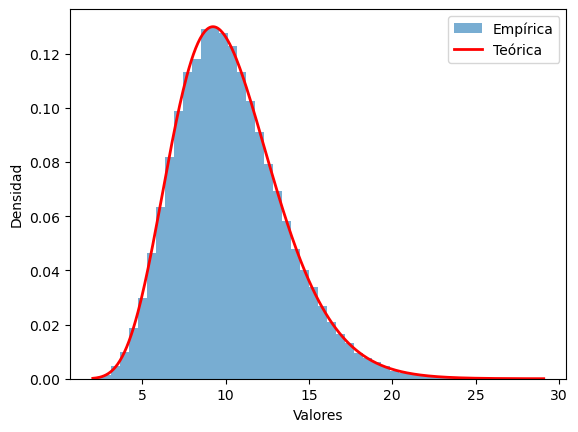

AR: 0.9860


In [36]:
gam_ar = GammaAR(10.25,1)
n = 100000
gam_ar.plot(n)
r = len(gam_ar.rejected)
E_ar = n/(n+r)
print('AR: {:.4f}'.format(E_ar))

## Simulando con numpy

In [37]:
import numpy.random as numprand

In [38]:
numprand.binomial(n=3,p=0.1,size=10)

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=int32)

In [39]:
numprand.exponential?

Signature: numprand.exponential(scale=1.0, size=None)
Docstring:
exponential(scale=1.0, size=None)

Draw samples from an exponential distribution.

Its probability density function is

.. math:: f(x; \frac{1}{\beta}) = \frac{1}{\beta} \exp(-\frac{x}{\beta}),

for ``x > 0`` and 0 elsewhere. :math:`\beta` is the scale parameter,
which is the inverse of the rate parameter :math:`\lambda = 1/\beta`.
The rate parameter is an alternative, widely used parameterization
of the exponential distribution [3]_.

The exponential distribution is a continuous analogue of the
geometric distribution.  It describes many common situations, such as
the size of raindrops measured over many rainstorms [1]_, or the time
between page requests to Wikipedia [2]_.

.. note::
    New code should use the `~numpy.random.Generator.exponential`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
scale : float or array_like of floats
    The s

In [40]:
numprand.triangular?

Signature: numprand.triangular(left, mode, right, size=None)
Docstring:
triangular(left, mode, right, size=None)

Draw samples from the triangular distribution over the
interval ``[left, right]``.

The triangular distribution is a continuous probability
distribution with lower limit left, peak at mode, and upper
limit right. Unlike the other distributions, these parameters
directly define the shape of the pdf.

.. note::
    New code should use the `~numpy.random.Generator.triangular`
    method of a `~numpy.random.Generator` instance instead;
    please see the :ref:`random-quick-start`.

Parameters
----------
left : float or array_like of floats
    Lower limit.
mode : float or array_like of floats
    The value where the peak of the distribution occurs.
    The value must fulfill the condition ``left <= mode <= right``.
right : float or array_like of floats
    Upper limit, must be larger than `left`.
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.

## Simulando con Pytorch

In [41]:
import torch

In [42]:
# ============================================================
# CREAR UNA DISTRIBUCIÓN NORMAL ESTÁNDAR N(0,1)
# ============================================================

normal = torch.distributions.Normal(0,1)

# Tensor escalar (un solo valor)
x = torch.tensor(0)

# cdf(x) = P(X <= x)
# Para una normal estándar, cdf(0) ≈ 0.5
print(normal.cdf(x))
# log_prob(x) = log(f(x)) donde f es la densidad
print(normal.log_prob(x))

tensor(0.5000)
tensor(-0.9189)


In [43]:
# Ahora x es un vector
x = torch.tensor([-1,0,1])

print(normal.cdf(x))
print(normal.log_prob(x))

tensor([0.1587, 0.5000, 0.8413])
tensor([-1.4189, -0.9189, -1.4189])


In [44]:
normal.sample?

Signature: normal.sample(sample_shape=torch.Size([]))
Docstring:
Generates a sample_shape shaped sample or sample_shape shaped batch of
samples if the distribution parameters are batched.
File:      c:\users\yael_\anaconda3\lib\site-packages\torch\distributions\normal.py
Type:      method

In [45]:

normal.sample(torch.Size([10]))

tensor([ 0.9309,  1.3309,  1.7599,  1.5268, -1.1481,  0.1760,  0.9660,  0.2239,
        -2.7788, -1.3660])

In [46]:
 # Fijamos la semilla para reproducibilidad
torch.random.manual_seed(1)
# 10x2 muestras independientes de N(0,1)
normal.sample(torch.Size([10,2]))

tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [ 0.8657,  0.2444],
        [-0.6629,  0.8073],
        [ 0.4391,  1.1712],
        [ 1.7674, -0.0954],
        [ 0.0612, -0.6177],
        [-0.7981, -0.1316],
        [-0.7984,  0.3357],
        [ 0.2753,  1.7163]])

In [47]:
 #Ahora creamos varias normales al mismo tiempo.
# mu tiene 3 valores -> tendremos 3 normales distintas.
mu =  torch.Tensor([-1.0,0.0,5.0])

sigma = torch.Tensor([1])

normal2 = torch.distributions.Normal(mu,sigma)

muestras = normal2.sample(torch.Size([1000]))

# Pedimos 1000 muestras.
# IMPORTANTE:
# El resultado tendrá dimensión [1000, 3]
# porque hay 3 distribuciones normales.
print(muestras)

tensor([[-0.8009,  0.0457,  5.1530],
        [-1.4757, -1.8821,  4.2235],
        [ 1.0242, -0.0865,  7.3571],
        ...,
        [ 0.5617, -0.4986,  4.9450],
        [ 0.1111, -0.7579,  4.7088],
        [-0.4424,  1.4039,  3.8753]])


In [48]:
muestras.mean(dim = 0)

tensor([-1.0136,  0.0221,  4.9559])

In [49]:
mu =  torch.Tensor([-1.0,0.0,5.0])
sigma = torch.Tensor([1,3,4])
normal2 = torch.distributions.Normal(mu,sigma)
muestras = normal2.sample((10,))
print(muestras)

tensor([[-1.5213,  1.6826,  8.1401],
        [-3.0749, -4.3604, -3.5724],
        [-1.2828, -0.2909,  1.1087],
        [-1.2487,  4.6964, -4.1270],
        [ 1.2302,  1.4876,  5.1850],
        [-1.6677, -0.9388,  4.3666],
        [-2.0162, -4.7758, 10.6226],
        [-0.3885,  0.7254,  2.6273],
        [ 0.8333, -1.3620, -0.1432],
        [-2.0179, -1.2927,  5.2746]])


In [50]:
muestras.std(dim=0)

tensor([1.3253, 2.8280, 4.7598])

In [51]:
p = torch.tensor([0.5, 0.1])
bernoulli = torch.distributions.Bernoulli(p)

muestras = bernoulli.sample((10,))
print(muestras)
print(muestras.shape)

tensor([[1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.]])
torch.Size([10, 2])


# Pruebas de Bondad de Ajuste

Sea $X_1,\dots,X_n$ una muestra aleatoria iid con función de distribución desconocida $F$.
El objetivo de las pruebas de bondad de ajuste es contrastar

$H_0:\; F = F_0$
contra
$H_1:\; F \neq F_0$

donde $F_0$ es una distribución teórica especificada.

A continuación se presentan dos pruebas fundamentales: Ji-cuadrada de Pearson y Kolmogorov–Smirnov.

---

# 1. Prueba Ji-cuadrada de Pearson

## Planteamiento

Sea una partición del espacio muestral en clases:

$A_1, A_2, \dots, A_k$.

Definimos:

- $O_i$: frecuencia observada en la clase $A_i$
- $E_i = n p_i(\theta)$: frecuencia esperada bajo $H_0$

donde $p_i(\theta) = P_\theta(X \in A_i)$.

Si el parámetro es desconocido se sustituye por un estimador $\hat{\theta}$.

---

## Estadístico de prueba

$$
\chi^2 =
\sum_{i=1}^k
\frac{(O_i - E_i)^2}{E_i}.
$$

---

## Distribución asintótica

Bajo $H_0$ y condiciones regulares:

$$
\chi^2 \xrightarrow{d} \chi^2_{k-1-r}
$$

donde:

- $k$ = número de clases
- $r$ = número de parámetros estimados

---

## Regla de decisión

Se rechaza $H_0$ si

$$
\chi^2 > \chi^2_{1-\alpha,\,k-1-r}.
$$

---

## Caso Poisson

Si $X \sim \text{Poisson}(\lambda)$ entonces

$$
p_i(\lambda) = e^{-\lambda}\frac{\lambda^i}{i!}.
$$

Si $\lambda$ es desconocido:

$$
\hat{\lambda} = \bar{X}.
$$

Los grados de libertad son:

$$
gl = k - 2.
$$

---

## Condició# 2. Prueba de Kolmogorov–Smirnov

## Función de distribución empírica

La función de distribución empírica se define como

$$
F_n(x) =
\frac{1}{n}
\sum_{i=1}^n
\mathbf{1}\{X_i \le x\}.
$$

Por el teorema de Glivenko–Cantelli:

$$
\sup_x |F_n(x) - F(x)| \to 0 \quad \text{c.s.}
$$

---

## Estadístico de Kolmogorov

$$
D_n =
\sup_x |F_n(x) - F_0(x)|.
$$

Este mide la máxima discrepancia entre la distribución empírica y la teórica.

---

## Relación con el puente browniano (resultado fundamental)

Bajo la hipótesis nula $H_0: F = F_0$, si $F_0$ es continua, entonces por el **teorema de Donsker** (o teorema funcional del límite central):

$$
\sqrt{n}\,\big(F_n(x) - F_0(x)\big)
\Rightarrow
B(F_0(x)),
$$

donde $B(t)$ es un **puente browniano** en $[0,1]$.

Equivalentemente, usando la transformación integral de probabilidad:

Si $U_i = F_0(X_i)$, entonces $U_i \sim \text{Uniforme}(0,1)$ y

$$
\sqrt{n}\,\big(F_n(x) - F_0(x)\big)
\Rightarrow
B(u), \quad u \in [0,1].
$$

---

## Definición de puente browniano

Un proceso $B(t)$, $t \in [0,1]$, es un puente browniano si:

- $B(0) = 0$
- $B(1) = 0$
- Es un proceso gaussiano con media cero
- Covarianza:

$$
\mathrm{Cov}(B(s), B(t))
=
\min(s,t) - st.
$$

Puede construirse como

$$
B(t) = W(t) - t W(1),
$$

donde $W(t)$ es un movimiento browniano estándar.

---

## Distribución límite del estadístico KS

Como consecuencia,

$$
\sqrt{n}D_n
=
\sup_x \left| \sqrt{n}(F_n(x)-F_0(x)) \right|
\Rightarrow
\sup_{0 \le t \le 1} |B(t)|.
$$

Por lo tanto, la distribución límite del estadístico es

$$
K =
\sup_{0 \le t \le 1} |B(t)|.
$$

---

## Distribución de Kolmogorov

La función de distribución es

$$
P(K \le z)
=
1 - 2\sum_{k=1}^{\infty}
(-1)^{k-1} e^{-2k^2 z^2}.
$$

Esta distribución es **libre de parámetros**, lo que explica por qué la prueba KS es no paramétrica.

---

## Regla de decisión

Se rechaza $H_0$ si

$$
D_n > \frac{c_\alpha}{\sqrt{n}}.
$$

Valores típicos:

| α | $c_\alpha$ |
|---|-----------|
0.10 | 1.22 |
0.05 | 1.36 |
0.01 | 1.63 |

---

## Interpretación probabilística profunda

La prueba KS mide la distancia suprema entre la distribución empírica y la verdadera.
Asintóticamente, esta diferencia se comporta como un puente browniano, es decir,
una fluctuación gaussiana condicionada a regresar a cero en el extremo del intervalo.
-cuadrada:

$$
\sum \frac{(O-E)^2}{E}
\approx
\int \frac{(f_n - f)^2}{f}.
$$

Kolmogorov:

$$
\sup_x |F_n - F|.
$$

Por tanto:

- Ji-cuadrada ≈ distancia tipo $L^2$
- KS ≈ distancia supremo


In [52]:
from scipy.stats import poisson, chisquare, kstest

In [53]:
size = 10000
data = np.array(poi.sample(size))

lam_hat = np.mean(data)

values, observed = np.unique(data, return_counts=True)

expected_probs = poisson.pmf(values, lam_hat)
expected = expected_probs * len(data)
expected = expected * observed.sum() / expected.sum()

chi2_stat, p_value = chisquare(observed, expected)

print("Lambda estimado:", lam_hat)
print("Chi-cuadrada:", chi2_stat)
print("p-value:", p_value)

Lambda estimado: 0.9981
Chi-cuadrada: 3.896709978097525
p-value: 0.79159463959416


In [54]:
size = 100000
glc = GLC()
data_u = glc.sample(size) 

stat, p_value = kstest(data_u, 'uniform',args=(0,1))

print("D:", stat)
print("p-value:", p_value)

D: 0.0030732037576255977
p-value: 0.30081462450570184
